# Smith Creek Water Level

Use full datalog available at https://docs.google.com/spreadsheets/d/1THImtlWGJqnXo7BfNR9S3TnL1TidwLVEFXZrE_Tv6H0/edit?usp=sharing. Save as .csv then open in text editor (VS code). Remove quotation marks by finding and replacing with nothing.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

In [2]:
filepath = os.path.join('Data', 'Water Level 2024 - Sheet1.csv')
df_full = pd.read_csv(filepath, header = None, parse_dates = [1])
df_full.columns = ['Device_ID', 'Datetime Transmission', 'Sensor', 'Event', 'Unix Time', 'Distance (cm)', 'Battery (V)', 'Charge (%)']
df_full.head()

,Device_ID,Datetime Transmission,Sensor,Event,Unix Time,Distance (cm),Battery (V),Charge (%)
0,e00fce680cdac6c15e5dfc75,2024-02-19 22:12:13,waterLevel_0001,waterLevel,1708398731,192.33333,4.13,95.29
1,e00fce686649823d18a012b5,2024-02-19 22:12:13,waterLevel_0000,waterLevel,1708398730,166.67500,4.14,97.66
2,e00fce680cdac6c15e5dfc75,2024-02-19 22:18:12,waterLevel_0001,waterLevel,1708399090,193.43889,4.13,95.29
3,e00fce686649823d18a012b5,2024-02-19 22:18:13,waterLevel_0000,waterLevel,1708399091,206.66945,4.14,97.66
4,e00fce680cdac6c15e5dfc75,2024-02-19 22:24:12,waterLevel_0001,waterLevel,1708399450,194.37361,4.13,95.29


## Interpret Unix time and get rid of junk dates (i.e., before cell connection)

In [3]:
# Filter out bad dates (currently using 1708538411 or 2/21/2024 13:00 ET)
df_full = df_full[df_full['Unix Time']>1708538411]

# to round off to nearest second
time_utc = pd.to_datetime(df_full.loc[:, 'Unix Time']*1000000000)
df_full.loc[:, 'Time (ET)'] = time_utc.dt.tz_localize('utc').dt.tz_convert('US/Eastern')

df_full.head()

,Device_ID,Datetime Transmission,Sensor,Event,Unix Time,Distance (cm),Battery (V),Charge (%),Time (ET)
347,e00fce680cdac6c15e5dfc75,2024-02-21 14:00:11,waterLevel_0001,waterLevel,1708542010,243.78889,4.04,84.34,2024-02-21 14:00:10-05:00
348,e00fce686649823d18a012b5,2024-02-21 14:00:12,waterLevel_0000,waterLevel,1708542010,406.23056,4.08,86.20,2024-02-21 14:00:10-05:00
349,e00fce680cdac6c15e5dfc75,2024-02-21 15:00:11,waterLevel_0001,waterLevel,1708545610,246.25139,4.04,84.34,2024-02-21 15:00:10-05:00
350,e00fce686649823d18a012b5,2024-02-21 15:00:13,waterLevel_0000,waterLevel,1708545611,405.70557,4.08,86.20,2024-02-21 15:00:11-05:00
351,e00fce680cdac6c15e5dfc75,2024-02-21 16:00:11,waterLevel_0001,waterLevel,1708549210,214.10695,4.03,84.34,2024-02-21 16:00:10-05:00


## Separate Sensors
Google Sheet contains data from all sensors in the waterLevel product that publish with eventName beginning with waterLevel. Separate data from the two sensors. 

In [4]:
df_wl0000 = df_full[df_full['Sensor']=='waterLevel_0000']
df_wl0001 = df_full[df_full['Sensor']=='waterLevel_0001']
df_wl0000.head()

,Device_ID,Datetime Transmission,Sensor,Event,Unix Time,Distance (cm),Battery (V),Charge (%),Time (ET)
348,e00fce686649823d18a012b5,2024-02-21 14:00:12,waterLevel_0000,waterLevel,1708542010,406.23056,4.08,86.20,2024-02-21 14:00:10-05:00
350,e00fce686649823d18a012b5,2024-02-21 15:00:13,waterLevel_0000,waterLevel,1708545611,405.70557,4.08,86.20,2024-02-21 15:00:11-05:00
352,e00fce686649823d18a012b5,2024-02-21 16:00:12,waterLevel_0000,waterLevel,1708549210,372.33057,4.07,86.20,2024-02-21 16:00:10-05:00
354,e00fce686649823d18a012b5,2024-02-21 17:00:25,waterLevel_0000,waterLevel,1708552810,336.35278,4.05,86.20,2024-02-21 17:00:10-05:00
356,e00fce686649823d18a012b5,2024-02-21 18:00:12,waterLevel_0000,waterLevel,1708556410,312.02777,4.04,86.06,2024-02-21 18:00:10-05:00


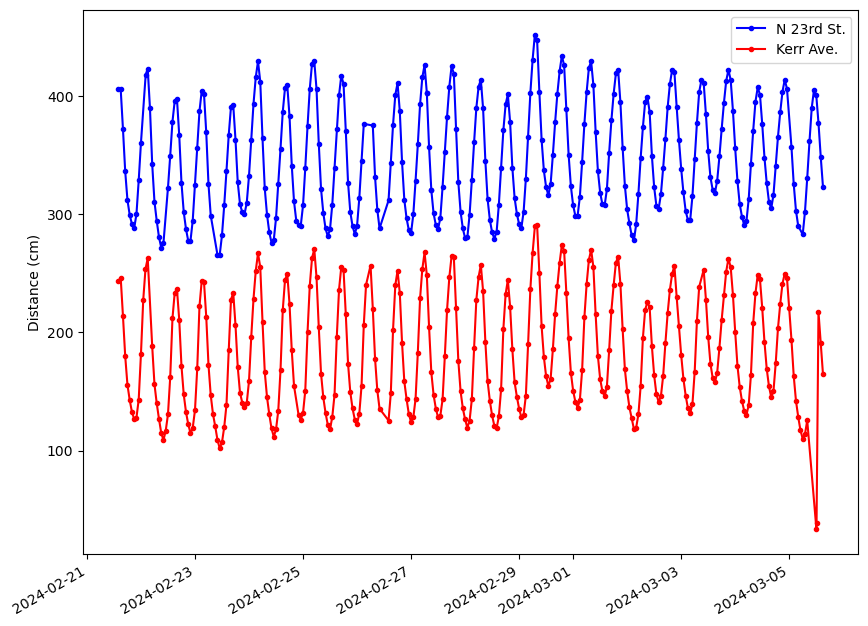

In [5]:
fig, axs = plt.subplots(figsize = (10, 8))
axs.plot(df_wl0000['Time (ET)'], df_wl0000['Distance (cm)'], 'b.-', label = 'N 23rd St.')
axs.plot(df_wl0001['Time (ET)'], df_wl0001['Distance (cm)'], 'r.-', label = 'Kerr Ave.')

axs.set_ylabel('Distance (cm)')
axs.legend()

fig.autofmt_xdate()

## Convert distance to water level
Using some known reference point, *a*, convert the distance from sensor to water surface to a water level.  
$H = a-x$  
where *H* is water level, *a* is reference height, and *x* is distance measured by ultrasonic distance sensor. All three should use same units. *a* and *x* are specific to their deployment locations.

$a_{N23rd,MLLW} =  430.7\ cm\ MLLW$  
$a_{Kerr,MLLW} =  269.1\ cm\ MLLW$  

or 

$a_{N23rd,NAVD88} =  351.5\ cm\ NAVD88$  
$a_{Kerr,NAVD88} =  189.9\ cm\ NAVD88$

In [6]:
a_N23rd = 351.5 # cm
a_Kerr = 189.9 # cm

df_wl0000.loc[:, 'Water Level (cm)'] = a_N23rd-df_wl0000.loc[:, 'Distance (cm)']
df_wl0001.loc[:, 'Water Level (cm)'] = a_Kerr-df_wl0001.loc[:, 'Distance (cm)']

/var/folders/9z/6wqx9_n10fxgqqh0dmf4kv6j7wvkzn/T/ipykernel_9413/4223107299.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_wl0000.loc[:, 'Water Level (cm)'] = a_N23rd-df_wl0000.loc[:, 'Distance (cm)']
/var/folders/9z/6wqx9_n10fxgqqh0dmf4kv6j7wvkzn/T/ipykernel_9413/4223107299.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_wl0001.loc[:, 'Water Level (cm)'] = a_Kerr-df_wl0001.loc[:, 'Distance (cm)']


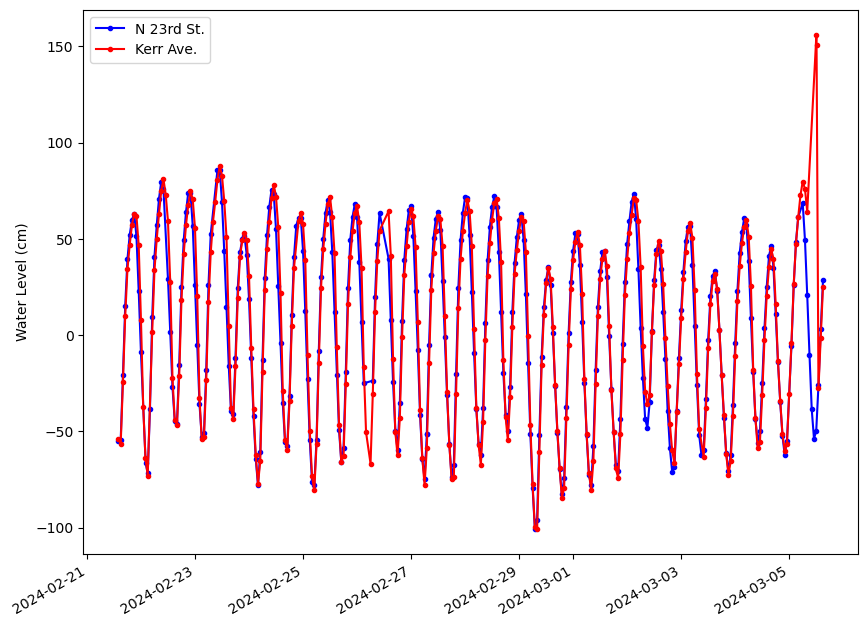

In [7]:
fig, axs = plt.subplots(figsize = (10, 8))
axs.plot(df_wl0000['Time (ET)'], df_wl0000['Water Level (cm)'], 'b.-', label = 'N 23rd St.')
axs.plot(df_wl0001['Time (ET)'], df_wl0001['Water Level (cm)'], 'r.-', label = 'Kerr Ave.')

axs.set_ylabel('Water Level (cm)')
axs.legend()

fig.autofmt_xdate()

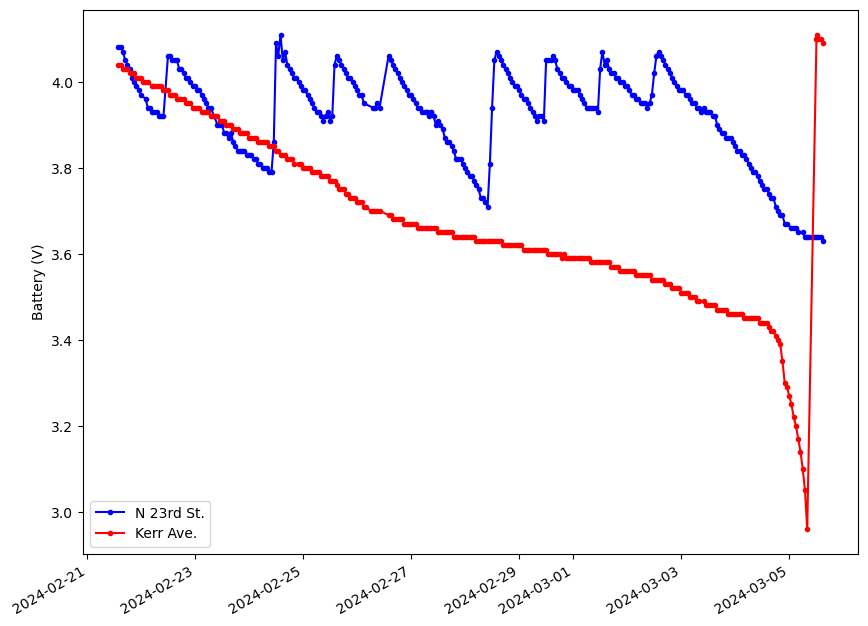

In [8]:
fig, axs = plt.subplots(figsize = (10, 8))
axs.plot(df_wl0000['Time (ET)'], df_wl0000['Battery (V)'], 'b.-', label = 'N 23rd St.')
axs.plot(df_wl0001['Time (ET)'], df_wl0001['Battery (V)'], 'r.-', label = 'Kerr Ave.')

axs.set_ylabel('Battery (V)')
axs.legend()

fig.autofmt_xdate()